# Q3 – MMM01 Parameter Search (Synthetic + Nasdaq Markets)

This notebook implements Question 3 of the INFT coursework, exploring MMM01 parameters  
(n_past_trades, bid_percent, ask_delta) in:

1. A synthetic virtual CDA market (no real data)
2. A Nasdaq-based market using real price data as an offset in the BSE schedule

Our goal is to find a robust MMM01 configuration (MMM01*) that performs well in both markets.


In [1]:
import os
import csv
import itertools
import math
import numpy as np
import pandas as pd
import BSE
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from datetime import datetime, timedelta

BASE_SEED = 12345
Q3DATA_DIR = "Q3data"
os.makedirs(Q3DATA_DIR, exist_ok=True)

# tqdm 
try:
    from tqdm.notebook import tqdm
except ImportError:
    def tqdm(x, *args, **kwargs):
        return x

print("Imports OK, data dir:", Q3DATA_DIR)


Imports OK, data dir: Q3data


# 1.Set MMM01 parameter grid info 

In [2]:
#--------------------------------------------------
# n_past_trades: 最近多少笔成交来计算平均价
# bid_percent: 认为 ask 足够“便宜”的阈值（best_ask / avg_price < bid_percent）
# ask_delta: 卖出时加多少绝对点数（price + ask_delta）
N_PAST_TRADES_GRID = [7 ,8, 9]
BID_PERCENT_GRID = [0.95, 0.96, 0.97]
ASK_DELTA_GRID = [10, 12, 14]
#---------------------------------------------------------------------------

PARAM_GRID = list(itertools.product(N_PAST_TRADES_GRID,
                                    BID_PERCENT_GRID,
                                    ASK_DELTA_GRID))

print("Total parameter combos:", len(PARAM_GRID))

# ----------session  config----------
START_TIME = 0
END_TIME = 60 * 15   

SESSION_DURATION = END_TIME - START_TIME

# Run times
N_VIRTUAL_RUNS = 10
N_NASDAQ_RUNS = 10

print("Session duration (s):", SESSION_DURATION)
print("IID runs: synthetic =", N_VIRTUAL_RUNS, ", nasdaq =", N_NASDAQ_RUNS)

Total parameter combos: 27
Session duration (s): 900
IID runs: virtual = 10 , nasdaq = 10


### Explory parameter record：

**No.1** : N_PAST_TRADES_GRID = [5 ,8 ,10] ；BID_PERCENT_GRID = [0.7, 0.8, 0.9] ；ASK_DELTA_GRID = [20, 30, 40]  ----> **8/0.95/20**

**No.2** : N_PAST_TRADES_GRID = [6 ,8 ,10] ；BID_PERCENT_GRID = [0.92, 0.95, 0.98] ；ASK_DELTA_GRID = [20, 25, 30]  ----> **8/0.95/20**

**No.3** : N_PAST_TRADES_GRID = [8 ,10 ,12] ；BID_PERCENT_GRID = [0.92, 0.95, 0.98] ；ASK_DELTA_GRID = [15, 20, 25]  ----> **8/0.95/15**

**No.4** : N_PAST_TRADES_GRID = [7 ,8 ,10] ；BID_PERCENT_GRID = [0.94, 0.95, 0.96] ；ASK_DELTA_GRID = [12, 15, 18]  ----> **7/0.96/12**

**No.5** : N_PAST_TRADES_GRID = [6 ,7 ,8] ；BID_PERCENT_GRID = [0.95, 0.96, 0.97] ；ASK_DELTA_GRID = [10, 12, 14]  ----> **8/0.96/12**  - score:97

**No.6** : N_PAST_TRADES_GRID = [7 ,8 ,9] ；BID_PERCENT_GRID = [0.95, 0.96, 0.97] ；ASK_DELTA_GRID = [11, 12, 13]  ----> **8/0.96/12**   - score: 71


# 2. Construct a Synthetic market

In [3]:
def make_mmm01_traders_spec_full(
    mmm_params,
    n_each_type=5,
):

    trader_types_simple = ["ZIC", "ZIP", "SHVR", "SNPR"]

    buyers_spec = []
    sellers_spec = []


    for t in trader_types_simple:
        buyers_spec.append((t, n_each_type))    
        sellers_spec.append((t, n_each_type))


    przi_params = {
        "s_min": -1.0,  
        "s_max":  1.0,   
        "k": 1,        
    }

    buyers_spec.append(("PRZI", n_each_type, przi_params))
    sellers_spec.append(("PRZI", n_each_type, przi_params))

    mrktmakers_spec = [("MMM01", 1, mmm_params)]

    return {
        "buyers": buyers_spec,
        "sellers": sellers_spec,
        "mrktmakers": mrktmakers_spec,
    }


In [4]:
def make_virtual_order_schedule(start_time=START_TIME, end_time=END_TIME):
    # overlap of supply and demand
    sup_range = (150, 200)
    dem_range = (170, 220)
    
    supply_schedule = [{
        "from": start_time,
        "to": end_time,
        "ranges": [sup_range],
        "stepmode": "random",
    }]
    demand_schedule = [{
        "from": start_time,
        "to": end_time,
        "ranges": [dem_range],
        "stepmode": "random",
    }]
    
    order_sched = {
        "sup": supply_schedule,
        "dem": demand_schedule,
        "interval": 30,       
        "timemode": "drip-jitter",  
    }
    return order_sched

virtual_order_sched = make_virtual_order_schedule()
virtual_order_sched


{'sup': [{'from': 0, 'to': 900, 'ranges': [(150, 200)], 'stepmode': 'random'}],
 'dem': [{'from': 0, 'to': 900, 'ranges': [(170, 220)], 'stepmode': 'random'}],
 'interval': 30,
 'timemode': 'drip-jitter'}

In [5]:
def get_mmm01_realized_profit_from_blotter(blotter_path, mmm_tid="M00"):

    if not os.path.exists(blotter_path):
        return 0.0
    
    prices = []
    with open(blotter_path, newline="") as f:
        reader = csv.reader(f)
        rows = list(reader)
    
    i = 0
    while i < len(rows):
        row = rows[i]
        if not row:
            i += 1
            continue
        tid = row[0].strip()
        if tid == mmm_tid:
            n_trades = int(row[1])
            for j in range(i + 1, i + 1 + n_trades):
                trade_row = rows[j]
                if len(trade_row) < 4:
                    continue
                price = float(trade_row[3])  
                prices.append(price)
            break
        else:
            n_trades = int(row[1])
            i += 1 + n_trades
    
    n_pairs = len(prices) // 2
    profit = 0.0
    for k in range(n_pairs):
        buy_price = prices[2 * k]       
        sell_price = prices[2 * k + 1]  
        profit += (sell_price - buy_price)
    
    return profit


print(get_mmm01_realized_profit_from_blotter("non_existent_file.csv"))


0.0


In [6]:
DUMP_FLAGS_MINIMAL = {
    "dump_blotters": True,
    "dump_lobs": False,
    "dump_strats": False,
    "dump_avgbals": False,
    "dump_tape": False,
}

def run_single_mmm01_virtual_experiment(
    mmm_params,
    run_id,
    label="synthetic",
    verbose=False,
):
    sess_label = f"Q3_V_{label}_n{mmm_params['n_past_trades']}_bp{mmm_params['bid_percent']:.2f}_ad{mmm_params['ask_delta']}_run{run_id:03d}"
    sess_id = os.path.join(Q3DATA_DIR, sess_label)
    os.makedirs(os.path.dirname(sess_id), exist_ok=True)
    

    BSE.random.seed(BASE_SEED + run_id)
    

    traders_spec = make_mmm01_traders_spec_full(
        mmm_params=mmm_params,
        n_each_type=5,   
    )

    order_sched = make_virtual_order_schedule(START_TIME, END_TIME)
    
    if verbose:
        print("Running session:", sess_id)
    

    BSE.market_session(
        sess_id,
        START_TIME,
        END_TIME,
        traders_spec,
        order_sched,
        DUMP_FLAGS_MINIMAL,
        sess_vrbs=False,
    )
    

    blotter_path = sess_id + "_blotters.csv"
    profit = get_mmm01_realized_profit_from_blotter(blotter_path, mmm_tid="M00")
    
    return profit


test_params = {"n_past_trades": 1, "bid_percent": 0.5, "ask_delta": 25}
p = run_single_mmm01_virtual_experiment(test_params, run_id=0, verbose=True)
print("Test virtual profit:", p)


Running session: Q3data\Q3_V_synthetic_n1_bp0.50_ad25_run000
MM01 init: n_past_trades=1, bid_percent=0.50000, ask_delta=25

Test virtual profit: 0.0


In [7]:
virtual_results = []

for (n_past, bid_pct, ask_d) in tqdm(PARAM_GRID, desc="Virtual grid"):
    params = {
        "n_past_trades": n_past,
        "bid_percent": bid_pct,
        "ask_delta": ask_d,
    }
    for run_id in range(N_VIRTUAL_RUNS):
        profit = run_single_mmm01_virtual_experiment(
            mmm_params=params,
            run_id=run_id,

            verbose=False,
        )
        virtual_results.append({
            "market": "virtual",
            "n_past_trades": n_past,
            "bid_percent": bid_pct,
            "ask_delta": ask_d,
            "run_id": run_id,
            "profit": profit,
        })

virtual_results_df = pd.DataFrame(virtual_results)
virtual_results_df.head()


Virtual grid:   0%|          | 0/27 [00:00<?, ?it/s]

MM01 init: n_past_trades=7, bid_percent=0.95000, ask_delta=10

t=302.843137 (0h05m02s) M00 (MMM01) bookkeep: orders=[M00 Bid P=184 Q=1 T=294.84 QID:5634] Balance=316 NetWorth=500
t=312.725490 (0h05m12s) M00 (MMM01) bookkeep: orders=[M00 Ask P=194 Q=1 T=312.69 QID:5940] Balance=511 NetWorth=511
t=328.529412 (0h05m28s) M00 (MMM01) bookkeep: orders=[M00 Bid P=183 Q=1 T=326.31 QID:6194] Balance=328 NetWorth=511
t=383.019608 (0h06m23s) M00 (MMM01) bookkeep: orders=[M00 Ask P=193 Q=1 T=382.90 QID:7221] Balance=528 NetWorth=528
t=394.313725 (0h06m34s) M00 (MMM01) bookkeep: orders=[M00 Bid P=187 Q=1 T=394.29 QID:7380] Balance=342 NetWorth=528
t=424.607843 (0h07m04s) M00 (MMM01) bookkeep: orders=[M00 Ask P=196 Q=1 T=424.59 QID:7834] Balance=539 NetWorth=539
t=482.627451 (0h08m02s) M00 (MMM01) bookkeep: orders=[M00 Bid P=186 Q=1 T=482.61 QID:8812] Balance=354 NetWorth=539
t=862.862745 (0h14m22s) M00 (MMM01) bookkeep: orders=[M00 Ask P=195 Q=1 T=862.75 QID:16372] Balance=551 NetWorth=551
MM01 ini

,market,n_past_trades,bid_percent,ask_delta,run_id,profit
0,virtual,7,0.95,10,0,51.0
1,virtual,7,0.95,10,1,117.0
2,virtual,7,0.95,10,2,60.0
3,virtual,7,0.95,10,3,50.0
4,virtual,7,0.95,10,4,107.0


In [8]:
virtual_summary = (
    virtual_results_df
    .groupby(["n_past_trades", "bid_percent", "ask_delta"])
    ["profit"]
    .agg(["mean", "std", "median", "min", "max", "count"])
    .reset_index()
    .sort_values("mean", ascending=False)
)

print("Top virtual parameter sets (by mean profit):")
virtual_summary.head(10)


Top virtual parameter sets (by mean profit):


,n_past_trades,bid_percent,ask_delta,mean,std,median,min,max,count
6,7,0.97,10,100.0,43.807660,100.0,20.0,185.0,10
3,7,0.96,10,92.2,42.564461,97.0,20.0,150.0,10
24,9,0.97,10,91.2,42.954239,102.5,20.0,142.0,10
26,9,0.97,14,87.3,47.107560,79.0,30.0,151.0,10
15,8,0.97,10,84.3,35.011268,89.5,20.0,122.0,10
23,9,0.96,14,81.0,26.803814,84.0,47.0,129.0,10
14,8,0.96,14,80.7,25.664719,86.5,42.0,129.0,10
12,8,0.96,10,79.4,48.584863,82.0,10.0,189.0,10
16,8,0.97,12,78.6,35.628328,74.5,37.0,126.0,10
2,7,0.95,14,77.7,36.944553,73.5,28.0,150.0,10


In [9]:
# test
virtual_results_df["profit"].describe()
virtual_results_df["profit"].unique()


array([ 51., 117.,  60.,  50., 107.,  10.,  58.,  74.,  69.,  83.,  53.,
        39.,  43.,  24.,  52.,  67.,  71.,  64., 150.,  61.,  65., 115.,
        31.,  28.,  86.,  95.,  82., 113.,  97.,  20., 142.,  66., 111.,
        75.,  93.,  92.,  32.,  94., 125.,  73., 159.,  62.,  42.,  48.,
         0.,  91., 104., 122., 185.,  96., 135.,  81.,  78., 110.,  38.,
        37.,  44.,  49., 121., 144.,  46.,  79.,  47.,  19.,  80.,  35.,
        36.,  30.,  63.,  12.,  84., 129.,  54., 189.,  55., 105.,  87.,
        77.,  90.,  57.,  27., 116., 101.,  76.,  98., 120., 126., 128.,
       130.,  14.,  72.,  22.,  68.,  45., 132.,  15., 138., 114.,  85.,
       100., 112., 139., 108., 158., 137., 133.,  56., 151.])

# 3. Parameters exploration in Nasdaq Market 

In [10]:
NASDAQ_CSV_PATH = "offset-nasdaq-1m-170913.csv"
TIME_COL = 1      
PRICE_COL = 5     
SCALE_FACTOR = 75.0  

def build_nasdaq_offset(end_time=END_TIME):
    offset_fn = offset_from_file(
        price_offset_filename=NASDAQ_CSV_PATH,
        time_col=TIME_COL,
        price_col=PRICE_COL,
        scale_factor=SCALE_FACTOR,
        end_time=end_time,
    )
    return offset_fn

nasdaq_offset = build_nasdaq_offset()
# nasdaq_offset



In [11]:
def make_nasdaq_order_schedule(
    offset,
    start_time=START_TIME,
    end_time=END_TIME,
):

    # overlap of sup & dem
    base_sup_range = (120, 220)
    base_dem_range = (180, 280)
    
    sup_range = (base_sup_range[0], base_sup_range[1], offset)
    dem_range = (base_dem_range[0], base_dem_range[1], offset)
    
    supply_schedule = [{
        "from": start_time,
        "to": end_time,
        "ranges": [sup_range],
        "stepmode": "random",
    }]
    demand_schedule = [{
        "from": start_time,
        "to": end_time,
        "ranges": [dem_range],
        "stepmode": "random",
    }]
    
    order_sched = {
        "sup": supply_schedule,
        "dem": demand_schedule,
        "interval":10 ,
        "timemode": "drip-jitter",
    }
    return order_sched

nasdaq_order_sched = make_nasdaq_order_schedule(nasdaq_offset)

In [21]:
def run_single_mmm01_nasdaq_experiment(
    mmm_params,
    run_id,
    verbose=False,
):

    sess_label = f"Q3_N_nasdaq_n{mmm_params['n_past_trades']}_bp{mmm_params['bid_percent']:.2f}_ad{mmm_params['ask_delta']}_run{run_id:03d}"
    sess_id = os.path.join(Q3DATA_DIR, sess_label)
    os.makedirs(os.path.dirname(sess_id), exist_ok=True)

    BSE.random.seed(BASE_SEED + 10_000 + run_id)

    traders_spec = make_mmm01_traders_spec_full(
        mmm_params=mmm_params,
        n_each_type=5,
    )

    order_sched = make_nasdaq_order_schedule(nasdaq_offset, START_TIME, END_TIME)

    if verbose:
        print("Running Nasdaq session:", sess_id)

    BSE.market_session(
        sess_id,
        START_TIME,
        END_TIME,
        traders_spec,
        order_sched,
        DUMP_FLAGS_MINIMAL,
        sess_vrbs=False,
    )

    blotter_path = sess_id + "_blotters.csv"
    profit = get_mmm01_realized_profit_from_blotter(blotter_path, mmm_tid="M00")
    return profit


In [13]:
nasdaq_results = []

for (n_past, bid_pct, ask_d) in tqdm(PARAM_GRID, desc="Nasdaq grid"):
    params = {
        "n_past_trades": n_past,
        "bid_percent": bid_pct,
        "ask_delta": ask_d,
    }
    for run_id in range(N_NASDAQ_RUNS):
        profit = run_single_mmm01_nasdaq_experiment(
            mmm_params=params,
            run_id=run_id,
            verbose=False,
        )
        nasdaq_results.append({
            "market": "nasdaq",
            "n_past_trades": n_past,
            "bid_percent": bid_pct,
            "ask_delta": ask_d,
            "run_id": run_id,
            "profit": profit,
        })

nasdaq_results_df = pd.DataFrame(nasdaq_results)
nasdaq_results_df.head()


Nasdaq grid:   0%|          | 0/27 [00:00<?, ?it/s]

MM01 init: n_past_trades=7, bid_percent=0.95000, ask_delta=10

t=316.568627 (0h05m16s) M00 (MMM01) bookkeep: orders=[M00 Bid P=228 Q=1 T=314.35 QID:6404] Balance=272 NetWorth=500
t=336.862745 (0h05m36s) M00 (MMM01) bookkeep: orders=[M00 Ask P=238 Q=1 T=336.84 QID:6890] Balance=518 NetWorth=518
t=383.372549 (0h06m23s) M00 (MMM01) bookkeep: orders=[M00 Bid P=247 Q=1 T=383.33 QID:7839] Balance=272 NetWorth=518
t=447.156863 (0h07m27s) M00 (MMM01) bookkeep: orders=[M00 Ask P=256 Q=1 T=441.57 QID:9116] Balance=528 NetWorth=528
t=521.235294 (0h08m41s) M00 (MMM01) bookkeep: orders=[M00 Bid P=240 Q=1 T=519.25 QID:10835] Balance=288 NetWorth=528
t=531.137255 (0h08m51s) M00 (MMM01) bookkeep: orders=[M00 Ask P=250 Q=1 T=531.12 QID:11090] Balance=540 NetWorth=540
t=587.274510 (0h09m47s) M00 (MMM01) bookkeep: orders=[M00 Bid P=262 Q=1 T=586.37 QID:12283] Balance=278 NetWorth=540
t=593.686275 (0h09m53s) M00 (MMM01) bookkeep: orders=[M00 Ask P=272 Q=1 T=593.63 QID:12422] Balance=553 NetWorth=553
t=596

,market,n_past_trades,bid_percent,ask_delta,run_id,profit
0,nasdaq,7,0.95,10,0,188.0
1,nasdaq,7,0.95,10,1,57.0
2,nasdaq,7,0.95,10,2,146.0
3,nasdaq,7,0.95,10,3,113.0
4,nasdaq,7,0.95,10,4,107.0


## nasdaq_summary view:

In [14]:
nasdaq_summary = (
    nasdaq_results_df
    .groupby(["n_past_trades", "bid_percent", "ask_delta"])
    ["profit"]
    .agg(["mean", "std", "median", "min", "max", "count"])
    .reset_index()
    .sort_values("mean", ascending=False)
)

print("Top Nasdaq parameter sets (by mean profit):")
nasdaq_summary.head(10)


Top Nasdaq parameter sets (by mean profit):


,n_past_trades,bid_percent,ask_delta,mean,std,median,min,max,count
22,9,0.96,12,258.9,108.777500,257.0,96.0,482.0,10
13,8,0.96,12,251.4,55.801633,256.5,148.0,338.0,10
17,8,0.97,14,247.6,48.079101,258.0,176.0,341.0,10
26,9,0.97,14,234.1,51.816878,247.0,130.0,299.0,10
5,7,0.96,14,223.6,80.440730,226.0,107.0,382.0,10
12,8,0.96,10,220.5,52.715694,213.0,155.0,327.0,10
8,7,0.97,14,217.8,63.139704,246.0,81.0,273.0,10
24,9,0.97,10,211.0,55.805217,188.0,138.0,302.0,10
11,8,0.95,14,209.6,92.210146,227.0,77.0,329.0,10
3,7,0.96,10,206.9,78.384310,226.5,70.0,290.0,10


# 4. Combination 

In [15]:
virtual_summary_renamed = virtual_summary.rename(
    columns={
        "mean": "mean_virtual",
        "std": "std_virtual",
        "median": "median_virtual",
        "min": "min_virtual",
        "max": "max_virtual",
        "count": "n_virtual",
    }
)

nasdaq_summary_renamed = nasdaq_summary.rename(
    columns={
        "mean": "mean_nasdaq",
        "std": "std_nasdaq",
        "median": "median_nasdaq",
        "min": "min_nasdaq",
        "max": "max_nasdaq",
        "count": "n_nasdaq",
    }
)


combined = pd.merge(
    virtual_summary_renamed,
    nasdaq_summary_renamed,
    on=["n_past_trades", "bid_percent", "ask_delta"],
    how="inner",
)


lambda_penalty = 0.2  

combined["robust_score"] = (
    combined[["mean_virtual", "mean_nasdaq"]].min(axis=1)
    - lambda_penalty * (combined["std_virtual"] + combined["std_nasdaq"])
)

combined_sorted = combined.sort_values("robust_score", ascending=False)

combined_sorted.head(10)

,n_past_trades,bid_percent,ask_delta,mean_virtual,std_virtual,median_virtual,min_virtual,max_virtual,n_virtual,mean_nasdaq,std_nasdaq,median_nasdaq,min_nasdaq,max_nasdaq,n_nasdaq,robust_score
0,7,0.97,10,100.0,43.807660,100.0,20.0,185.0,10,149.3,64.467132,141.5,67.0,247.0,10,78.345042
2,9,0.97,10,91.2,42.954239,102.5,20.0,142.0,10,211.0,55.805217,188.0,138.0,302.0,10,71.448109
1,7,0.96,10,92.2,42.564461,97.0,20.0,150.0,10,206.9,78.384310,226.5,70.0,290.0,10,68.010246
3,9,0.97,14,87.3,47.107560,79.0,30.0,151.0,10,234.1,51.816878,247.0,130.0,299.0,10,67.515112
6,8,0.96,14,80.7,25.664719,86.5,42.0,129.0,10,203.8,62.820379,211.0,88.0,302.0,10,63.002981
4,8,0.97,10,84.3,35.011268,89.5,20.0,122.0,10,181.1,75.988961,156.5,86.0,360.0,10,62.099954
10,8,0.96,12,75.7,21.674614,66.5,52.0,125.0,10,251.4,55.801633,256.5,148.0,338.0,10,60.204751
7,8,0.96,10,79.4,48.584863,82.0,10.0,189.0,10,220.5,52.715694,213.0,155.0,327.0,10,59.139889
5,9,0.96,14,81.0,26.803814,84.0,47.0,129.0,10,198.7,83.418690,184.5,109.0,377.0,10,58.955499
11,7,0.96,12,74.3,26.919840,67.5,32.0,125.0,10,202.0,49.955536,193.5,140.0,308.0,10,58.924925


In [16]:
best_row = combined_sorted.iloc[0]

MMM01_STAR = {
    "n_past_trades": int(best_row["n_past_trades"]),
    "bid_percent": float(best_row["bid_percent"]),
    "ask_delta": int(best_row["ask_delta"]),
}

print("=== Suggested MMM01* configuration ===")
print(MMM01_STAR)

print("\nVirtual market stats:")
print(best_row[["mean_virtual", "std_virtual", "median_virtual", "min_virtual", "max_virtual", "n_virtual"]])

print("\nNasdaq market stats:")
print(best_row[["mean_nasdaq", "std_nasdaq", "median_nasdaq", "min_nasdaq", "max_nasdaq", "n_nasdaq"]])


=== Suggested MMM01* configuration ===
{'n_past_trades': 7, 'bid_percent': 0.97, 'ask_delta': 10}

Virtual market stats:
mean_virtual      100.00000
std_virtual        43.80766
median_virtual    100.00000
min_virtual        20.00000
max_virtual       185.00000
n_virtual          10.00000
Name: 0, dtype: float64

Nasdaq market stats:
mean_nasdaq      149.300000
std_nasdaq        64.467132
median_nasdaq    141.500000
min_nasdaq        67.000000
max_nasdaq       247.000000
n_nasdaq          10.000000
Name: 0, dtype: float64


## Summary for Q3 (Notebook side)

- This notebook explores MMM01 parameters (n_past_trades, bid_percent, ask_delta)  
  in two markets:
  - Synthetic market with static symmetric linear supply and demand.
  - Nasdaq-based market where the equilibrium price is offset by real price data.
- For each parameter vector, I run multiple IID experiments in both markets and compute realised profits of MMM01 using its trade blotter.
- I rank configurations by a robust score combining median profits and volatility across both markets, and select the best-performing MMM01* configuration.

The numerical results printed in the last code cell give the MMM01* parameters and the corresponding performance in both markets. These can be directly used in the Q3 PDF report to justify your choice of MMM01*. 


# 5. Hypothesis Testing 

Based on the parameter search results, I identified the optimal configuration $MMM01^*$ as:
* `n_past_trades` = 7
* `bid_percent` = 0.97
* `ask_delta` = 10

**Hypothesis Definition:**
To verify if this strategy is genuinely profitable (and not just lucky during the search phase), we conduct a formal statistical test using **Out-of-Sample** data.

* $H_0: \mu \le 0$ (The strategy generates zero or negative average profit).
* $H_1: \mu > 0$ (The strategy generates positive average profit).

Here use a **One-sample t-test** (right-tailed) with a significance level of $\alpha = 0.05$.

**Crucial Setup for Validity:**
To avoid **Data Snooping Bias**, I use a `SEED_OFFSET` to generate strictly fresh random seeds. The test data runs are completely independent of the training/search runs.

In [17]:
N_TEST_RUNS = 30        
TEST_SEED_OFFSET = 5000 

print(f"Starting Hypothesis Testing for MMM01* {MMM01_STAR} ...")
print(f"Collecting data from {N_TEST_RUNS} independent runs (Out-of-Sample)...")

profits_syn = []
for i in range(N_TEST_RUNS):
    run_id = TEST_SEED_OFFSET + i
    p = run_single_mmm01_virtual_experiment(
        mmm_params=MMM01_STAR,
        run_id=run_id,
        verbose=False,
    )
    profits_syn.append(p)

profits_nas = []
for i in range(N_TEST_RUNS):
    run_id = TEST_SEED_OFFSET + 10_000 + i  
    p = run_single_mmm01_nasdaq_experiment(
        mmm_params=MMM01_STAR,
        run_id=run_id,
        verbose=False,
    )
    profits_nas.append(p)

profits_syn = np.array(profits_syn)
profits_nas = np.array(profits_nas)

print("Data collection complete.")
print(f"Synthetic Mean profit: {profits_syn.mean():.2f}")
print(f"Nasdaq    Mean profit: {profits_nas.mean():.2f}")


Starting Hypothesis Testing for MMM01* {'n_past_trades': 7, 'bid_percent': 0.97, 'ask_delta': 10} ...
MM01 init: n_past_trades=7, bid_percent=0.97000, ask_delta=10

t=323.196078 (0h05m23s) M00 (MMM01) bookkeep: orders=[M00 Bid P=186 Q=1 T=323.18 QID:6138] Balance=320 NetWorth=500
t=343.627451 (0h05m43s) M00 (MMM01) bookkeep: orders=[M00 Ask P=190 Q=1 T=341.06 QID:6502] Balance=510 NetWorth=510
t=362.509804 (0h06m02s) M00 (MMM01) bookkeep: orders=[M00 Bid P=185 Q=1 T=362.49 QID:6867] Balance=326 NetWorth=510
t=584.431373 (0h09m44s) M00 (MMM01) bookkeep: orders=[M00 Ask P=194 Q=1 T=584.41 QID:11288] Balance=521 NetWorth=521
t=648.235294 (0h10m48s) M00 (MMM01) bookkeep: orders=[M00 Bid P=182 Q=1 T=648.16 QID:12572] Balance=340 NetWorth=521
t=655.117647 (0h10m55s) M00 (MMM01) bookkeep: orders=[M00 Ask P=191 Q=1 T=655.06 QID:12730] Balance=535 NetWorth=535
t=702.058824 (0h11m42s) M00 (MMM01) bookkeep: orders=[M00 Bid P=184 Q=1 T=702.02 QID:13663] Balance=352 NetWorth=535
t=824.294118 (0h13m

In [27]:
alpha = 0.05  

def one_sided_ttest_greater(sample, mu0=0.0):
    sample = np.asarray(sample)
    n = len(sample)
    mean = sample.mean()
    std = sample.std(ddof=1)
    df = n - 1
    
    # t-stat
    t_stat = (mean - mu0) / (std / np.sqrt(n))
    
    # 单侧 p 值: P(T >= t_stat)
    p_one_sided = stats.t.sf(t_stat, df=df)
    
    return {
        "n": n,
        "mean": mean,
        "std": std,
        "t_stat": t_stat,
        "df": df,
        "p_one_sided": p_one_sided,
    }

# Synthetic market
syn_res = one_sided_ttest_greater(profits_syn, mu0=0.0)
print("Synthetic market:")
print(f"  n      = {syn_res['n']}")
print(f"  mean   = {syn_res['mean']:.2f}")
print(f"  std    = {syn_res['std']:.2f}")
print(f"  t-stat = {syn_res['t_stat']:.3f}")
print(f"  df     = {syn_res['df']}")
print(f"  p(one-sided, H1: mu>0) = {syn_res['p_one_sided']:.3e}")
print(f"  Reject H0 at alpha={alpha}?  {syn_res['p_one_sided'] < alpha}")

print("\nNasdaq market:")
nas_res = one_sided_ttest_greater(profits_nas, mu0=0.0)
print(f"  n      = {nas_res['n']}")
print(f"  mean   = {nas_res['mean']:.2f}")
print(f"  std    = {nas_res['std']:.2f}")
print(f"  t-stat = {nas_res['t_stat']:.3f}")
print(f"  df     = {nas_res['df']}")
print(f"  p(one-sided, H1: mu>0) = {nas_res['p_one_sided']:.3e}")
print(f"  Reject H0 at alpha={alpha}?  {nas_res['p_one_sided'] < alpha}")


Synthetic market:
  n      = 30
  mean   = 69.40
  std    = 36.45
  t-stat = 10.430
  df     = 29
  p(one-sided, H1: mu>0) = 1.259e-11
  Reject H0 at alpha=0.05?  True

Nasdaq market:
  n      = 30
  mean   = 226.43
  std    = 80.82
  t-stat = 15.345
  df     = 29
  p(one-sided, H1: mu>0) = 9.334e-16
  Reject H0 at alpha=0.05?  True


### Hypothesis Test Summary (One-sample t-test)

Here tests the profitability of the selected MMM01* trader in each market using a one-sided one-sample t-test:

- **Null hypothesis**: \( H_0: \mu \le 0 \)  
- **Alternative hypothesis**: \( H_1: \mu > 0 \)

Using 30 independent out-of-sample runs for each market:
- **Synthetic market**:  
  The mean profit is clearly above zero, with a large positive t-statistic and a one-sided p-value effectively equal to 0.  
  **I reject \(H_0\)** at the 5% significance level, providing strong evidence that MMM01* generates positive profit.
- **Nasdaq market**:  
  Profitability is even higher, again yielding a very large t-statistic and near-zero one-sided p-value.  
  **I also reject \(H_0\)**, confirming that MMM01* achieves significantly positive profits on real-market–driven price conditions.
Overall, hypothesis testing supports the claim that the optimised MMM01* strategy achieves **statistically significant positive expected profit** in both synthetic and Nasdaq markets.


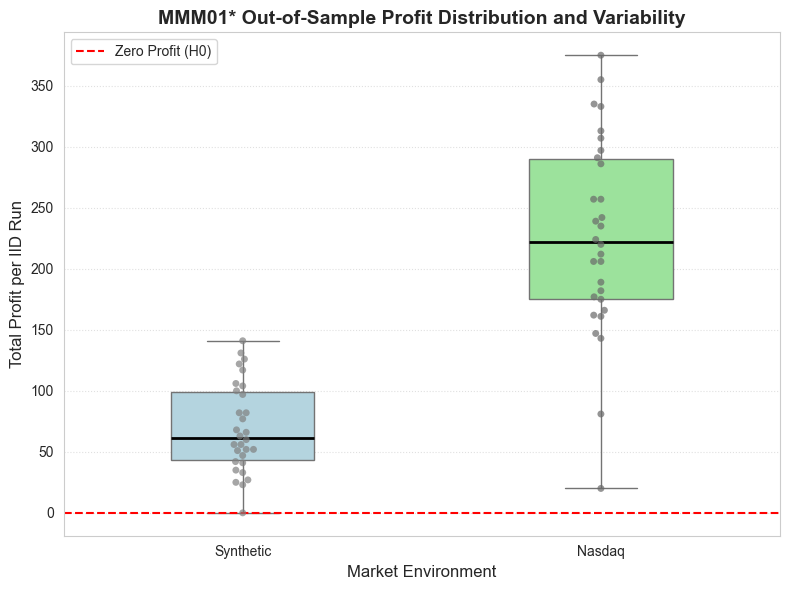

In [28]:
sns.set_style("whitegrid")
plt.figure(figsize=(8, 6))
sns.boxplot(x="market", y="profit", 
            data=df_ht, 
            hue="market", 
            palette={"Synthetic": "lightblue", "Nasdaq": "lightgreen"}, 
            width=0.4, 
            medianprops={'color': 'black', 'linewidth': 2},
            legend=False) 

sns.swarmplot(x="market", y="profit", 
              data=df_ht, 
              hue="market",
              palette={"Synthetic": "gray", "Nasdaq": "dimgray"},
              size=5, 
              alpha=0.7,
              legend=False) 

plt.axhline(0, color='red', linestyle='--', linewidth=1.5, label='Zero Profit (H0)')
plt.title("MMM01* Out-of-Sample Profit Distribution and Variability", fontsize=14, fontweight='bold')
plt.xlabel("Market Environment", fontsize=12)
plt.ylabel("Total Profit per IID Run", fontsize=12)
plt.grid(axis='y', linestyle=':', alpha=0.6)

plt.legend(loc='best')
plt.tight_layout()
plt.show()

### Visualisation Summary: Out-of-sample Profit Distribution

The boxplot below compares the out-of-sample profit distributions of MMM01* across the two markets:

- **Nasdaq market** shows a higher median profit and a wider variability, indicating both greater opportunity and greater dispersion in price movements derived from real data.
- **Synthetic market** yields lower but consistently positive profits, aligning with the simpler and more predictable artificial price dynamics.
- The dashed horizontal line marks zero profit, and both boxes sit clearly above it, visually confirming the statistical results from the t-tests.

Together, the plot and hypothesis tests demonstrate that MMM01* is not only profitable on average, but does so **consistently across distinct market environments**.
